# Reinforcement Learning

Reinforcement learning algorithms solve MDP-based control problems having the agent interact with
the environment (i.e., sampling) and learning from its experience. In order to do so, the agent will
try to maximize the expected return, or _expected cumulative reward_ (reward hypothesis).

## Type of Tasks

Before we proceed, let's introduce some useful concepts. There are two types of RL tasks:

 * **Episodic:** The task has one or more end (or _terminal_) states. For example, our grid world
   robot task ends either in the bomb or in the target.
 * **Continuous:** The task never ends, there are no terminal states. The agent keeps interacting
   with the environment (e.g., stock trading agent).

## Approaches

Finally, there are two main approaches for solving an RL problem:

 * **Value-based:** The agent learns an optimal value function (e.g., $Q(s,a)$), and then derives
   the optimal policy from it (see previous lecture). For now, we will focus on these methods.
 * **Policy-based:** The agent learns an optimal policy directly. We will learn about a popular
   category of algorithms of this kind later on (i.e., _policy gradient_ methods).

In [1]:
# For reproducibility.
from util.gymnastics import init_random
init_random()

## An Updated Grid World

To examine our RL algorithms, we will use a slightly more complicated version of our grid world.

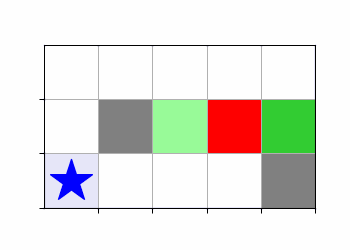

In [2]:
from util.gridworld import Grid, GridMDP, run_simulation, RANDOM_POLICY

WORLD_GRID = Grid([
    'EEEEE',
    'EWTNG',
    'SEEEW',
])

MDP = GridMDP(WORLD_GRID, gamma=0.9)

run_simulation(MDP, RANDOM_POLICY)

## Exponential Smoothing

How do we refine the expected value of a variable `X` given a series of samples? One technique that
we will use extensively is iteratively applying an
[_exponential moving average_](https://en.wikipedia.org/wiki/Exponential_smoothing) of the samples.

$$
X_{t+1} =  (1 - \alpha) X_t + \alpha X_{t+1}
$$

Basically, the adjusted value after sampling is a "blend" of the old value adjusted by the scaled
value of the new sample. $\alpha$ is the scaling factor (or, _learning rate_). We can rewrite the
above as:

$$
X_{t+1} =  X_t + \alpha (X_{t+1} - X_t)
$$

Where the difference between the new and old value is effectively an error $\delta$ scaled by the
learning rate $\alpha$. You will see why this formula is very important shortly.

In [3]:
import numpy as np

# Samples 1M values from a normal distribution with mean pi.
samples = np.random.normal(loc=3.14159265, scale=1.618033, size=(1_000_000,))

def estimate_mean(samples, alpha=0.0001) -> float:
    """Approximates the expected value using exponential smoothing."""
    value = samples[0]
    for sample in samples[1:]:
        value = value + alpha*(sample-value)
    return value

# This should print a value very close to 3.14 :)
print(f'Estimated expected value: {estimate_mean(samples):.2f}')

Estimated expected value: 3.15


## Monte Carlo Methods

Monte Carlo methods apply to episodic tasks. The intuition is that we can simulate entire episodes
and compute the actual return with which we can then update our value function.

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [G_t - Q(S_t, A_t)] 
$$

Monte Carlo methods do not introduce _bias_ in the estimation (because they use the actual return at
the end of the episode), but they might have high _variance_.

### Episode Generation

In [6]:
from util.gridworld import GridEnv, State, Action
from typing import Callable, TypeAlias

# For simplicity, we define a policy as a function that returns an action given a state.
# TODO: Define the 'Policy' typealias.
Policy:  TypeAlias = Callable[[State],Action]

# An episode instead is a list of tuples (state, action, reward).
# TODO: Define the 'Episode' typealias.
Episode: TypeAlias = list[tuple[State,Action,float]]

In [7]:
# Test our definition
assert Policy == Callable[[State], Action]
assert Episode == list[tuple[State, Action, float]]

In [23]:
def generate_episode(env: GridEnv, policy: Policy, max_t=10) -> Episode:
    """Generates an Monte Carlo episode in the Grid World environment GridEnv."""
    t = 0
    episode = []
    state = env.reset()
    while t < max_t:
        # TODO: select an action via the policy
        action: Action = policy(state)
        # TODO: get next_state, reward, done from the environment.
        next, reward, done = env.step(action)
        # TODO: record the step in the episode list.
        episode.append((state, action, reward))
        # TODO: Update state, time, and check for completion.
        t+=1
        state = next
        if done:
            break
    return episode

In [25]:
# Test
test_env = GridEnv(MDP)
test_policy = lambda _: Action.LEFT
test_episode = generate_episode(test_env, test_policy, max_t=3)
assert len(test_episode) == 3
assert test_episode[0] == (State(0, 0), Action.LEFT, 0.0)
assert test_episode[1] == (State(0, 0), Action.LEFT, 0.0)
assert test_episode[2] == (State(0, 0), Action.LEFT, 0.0)

test_policy = lambda s: Action.UP if s == State(3, 0) else Action.RIGHT
test_episode = generate_episode(test_env, test_policy)
assert len(test_episode) == 4
assert test_episode[0] == (State(0, 0), Action.RIGHT, 0.0)
assert test_episode[1] == (State(1, 0), Action.RIGHT, 0.0)
assert test_episode[2] == (State(2, 0), Action.RIGHT, 0.0)
assert test_episode[3] == (State(3, 0), Action.UP, -9.0)

But _how_ do we choose the actions in our Monte Carlo algorithm?

### Greedy and ε-greedy Policy

A _greedy_ policy always chooses the action that maximizes the Q function in the current state.

An _ε-greedy_ policy chooses any other action (other than the best action) with probability
$\frac{\epsilon}{n_A}$, where $n_A$ is the number of available actions. Hence, if ε is `1`,
the policy becomes the random policy; if ε is `0`, the policy is greedy instead.

In [26]:
from util.gridworld import QTable

def greedy_policy(qtable: QTable) -> Policy:
    """Returns the greedy policy for the specified QTable."""
    # TODO: Return the policy lambda for action selection using the best action from QTable.
    optimal_policy = lambda s: qtable.best_action(s)
    return optimal_policy

In [27]:
# Test the implementation
state_0 = State(0, 0)
state_1 = State(1, 0)
test_qtable = QTable([state_0, state_1], list(Action))

test_qtable[state_0, Action.DOWN]  = 0.5
test_qtable[state_0, Action.LEFT]  = 1.5
test_qtable[state_0, Action.RIGHT] = 0.8
test_qtable[state_1, Action.UP]    = 0.1

test_greedy_policy = greedy_policy(test_qtable)

assert test_greedy_policy(state_0) == Action.LEFT
assert test_greedy_policy(state_1) == Action.UP

In [38]:
from util.gridworld import QTable

def epsilon_greedy_policy(qtable: QTable, epsilon: float) -> Policy:
    """Returns the epsilon-greedy policy for the specified QTable."""
    def choose_action(state: State):
        # TODO: The probability of the best action is (1 - epsilon + epsilon / nA), while the
        #       other actions have probability (epsilon / nA). Compute those and choose the action.
        #       Use np.random.choice for sampling :)
        nA = qtable.nA
        probs = [epsilon/nA] * nA
        best_action = qtable.best_action(state)
        b_idx = qtable.actions.index(best_action)
        probs[b_idx]=1-epsilon+epsilon/nA
        return np.random.choice(qtable.actions, p=probs)
    return choose_action

In [39]:
# Test the implementation
# Approximate tests... hopefully good enough to find big bugs :)
state_0 = State(0, 0)
state_1 = State(1, 0)
test_qtable = QTable([state_0, state_1], list(Action))

test_qtable[state_0, Action.DOWN]  = 0.5
test_qtable[state_0, Action.LEFT]  = 1.5
test_qtable[state_0, Action.RIGHT] = 0.8
test_qtable[state_1, Action.UP]    = 0.1

def probe_actions(policy, state) -> list[Action]:
    return dict.fromkeys([policy(state) for _ in range(5_000)])

test_egreedy_policy = epsilon_greedy_policy(test_qtable, epsilon=1.0)
assert len(probe_actions(test_egreedy_policy, state_0)) == 4
assert len(probe_actions(test_egreedy_policy, state_1)) == 4

test_egreedy_policy = epsilon_greedy_policy(test_qtable, epsilon=0.0)
assert len(probe_actions(test_egreedy_policy, state_0)) == 1
assert len(probe_actions(test_egreedy_policy, state_1)) == 1

**Note:** This implementation technique (i.e., returning a function) is not optimal and definitely
not efficient. But it serves well for learning purposes.

#### Decay Epsilon with Generator

In [42]:
def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Convenient generator function to generate and decy epsilon."""
    # TODO: eps starts at eps_start :)
    eps = eps_start
    while True:
        yield eps
        eps = max(eps*eps_decay,eps_min)


In [43]:
# Test the implementation!
eps = epsilon_gen(1.0, 0.5, 0.1)

assert next(eps) == 1.0
assert next(eps) == 0.5
assert next(eps) == 0.25
assert next(eps) == 0.125
assert next(eps) == 0.1
assert next(eps) == 0.1

### Monte Carlo Algorithm

In [14]:
def monte_carlo(env: GridEnv, num_episodes, alpha=0.02, eps_start=1.0, start_q: QTable = None):
    """A Monte Carlo algorithm for reinforcement learning."""
    # TODO: Initialize the QTable (use start_q if provided, you'll see why later)
    Q = start_q if start_q != None else QTable(env.mdp.all_states,env.mdp.all_actions)

    # TODO: Prepare to generate epsilon creating the generator.
    epsilon = 

    # Iterate until we reached the maximum number of episodes for learning.
    for i_episode in range(1, num_episodes + 1):
        # TODO: Generate an episode by following epsilon-greedy policy.
        policy = None
        episode = None

        # TODO: Unpack the episode in a tuple of (list[states], list[actions], list[rewards]).
        #       Hint: use the zip function!
        states, actions, rewards = None

        # TODO: Conveniently compute the discounts first. We can do this b/c we can compute all the
        #       expected returns at each timestep (having all the rewards).
        #       The discounts are: [1, gamma, gamma^2, gamma^3, ...] for the length of the episode.
        discounts = None

        # For each step / transition in the environment, let's update the QTable according to the
        # update rule of Monte Carlo methods defined above.
        for t, state in enumerate(states):
            # TODO: Get the action at timestep `t` and the current state-action value.
            action = None
            old_Q = None
            # TODO: Compute the total return. Recall that:
            #       G_0 = R_1 + gamma * R_2 + gamma^2 * R_3 + ... (R1 is found at index 0)
            #       Hint: sum rewards _from_ `t` onward, while select discounts _until_ `t`. That is
            #       because discounts always start from the beginning even if rewards "shift".
            G_t = None
            Q[state, action] = None

        # Monitor progress
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}.", end="")

    # TODO: Determine the optimal policy  (i.e., the greedy policy on the computed QTable).
    policy = None
    return policy, Q

In [ ]:
ENV = GridEnv(MDP)

# With minimal exploration
biased_q = QTable(ENV.mdp.all_states, ENV.mdp.all_actions)
biased_q[State(0, 0), Action.RIGHT] = 0.1
biased_q[State(1, 0), Action.RIGHT] = 0.1
biased_q[State(2, 0), Action.UP]    = 0.1

minimal_exploration_policy, Q = monte_carlo(ENV, 100_000, eps_start=0.05, start_q=biased_q)
run_simulation(ENV.mdp, minimal_exploration_policy)

In [ ]:
# With exploration
optimal_policy, Q = monte_carlo(ENV, 100_000, start_q=biased_q)
run_simulation(ENV.mdp, optimal_policy)

### Exploration vs. Exploitation Tradeoff

We can prove that MC converges to the optimal policy when these conditions are met:

 * Every state-action pair is visited infinitely many times; and
 * The policy converges to a policy that is greedy with respect to the action-value function Q.

These are called the GLIE (Greedy in the Limit with Infinite Exploration) conditions, and guarantee
that the agent continues exploring for all time steps, and grdually exploits more exploring less.

Try to tune `alpha` and `epsilon` and see the effects on the performance of the algorithm!

## Temporal Difference Methods

Monte Carlo methods need to wait until the end of the episode to update our value estimates. Could
we find a way to integrate knowledge earlier than that? Temporal Difference (TD) methods come to the
rescue: they update the current value estimate based on the immediate reward and _another_ estimate.
Hence, the update rule looks something like this:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \{[R_t + \gamma V^{estimate}(S_{t+1})] - Q(S_t, A_t)\}
$$


$R_t + \gamma V^{estimate}(S_{t+1})$ is called the _TD target_. If our estimate was perfect, you can
notice it is effectively equivalent to $G_t$. Then, the _TD error_ $\delta^{TD}$ is:
$TD^{target} - Q(S_t, A_t)$. The equation above can be simplified as:

$$
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \delta^{TD}
$$

Choosing the estimate of the value function is what differentiates various TD algorithms.

### Q Learning

Q Learning is probably the most popular TD algorithm. In Q Learning, we choose the estimate of the
next value as: $\max Q(S_{t+1}, A_{t+1})$.

In [17]:
def q_learning(env: GridEnv, num_episodes, alpha=0.02, max_t=10):
    """Runs Q Learning."""
    # TODO: Initialize the QTable, and the epsilon generator.
    Q = None
    epsilon = None
    # Run for the maximum number of episodes passed as input.
    for i_episode in range(1, num_episodes+1):
        t = 0
        state = env.reset()
        while True:
            # TODO: Select an action with an epsilon greedy policy using Q.
            policy = None
            action = None
            # TODO: Interact with the environment
            next_state, reward, done = None
            # TODO: Store the current Q(s,a) value.
            cur_value = None
            # TODO: Determine the next_action using maxQ.
            next_action = None
            # TODO: Compute the TD target.
            td_target = None
            # TODO: Compute the TD error.
            td_error  = None
            # TODO: Update Q with the temporal-difference update rule.
            Q[state, action] = None

            # Update the state for the next cycle, and check for episode completion.
            state = next_state
            t = t + 1
            if done or t >= max_t:
                break
        # Monitor and debugging messages.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
    # TODO: Return the optimal policy as the greedy policy on Q.
    policy = None
    return policy, Q

In [ ]:
opt_policy, Q = q_learning(ENV, 100_000)
run_simulation(ENV.mdp, opt_policy)

In order to converge, Q Learning needs to explore enough and eventually make the learning rate small
enough, but not decrease it too quickly either... :)

### Off-Policy vs. On-Policy

Q Learning is an _off-policy_ algorithm: the policy function is learnt by estimating the value of
the next state using a separate policy (i.e., the greedy policy, maximizing the current Q value)
compared to the policy that is actually followed (i.e., $\epsilon$-greedy).

That is different from _on-policy_ learning, where we learn and refine the policy function using
actions taken via our current followed and learnt policy $\pi(a|s)$. See [this post](https://stats.stackexchange.com/questions/184657/what-is-the-difference-between-off-policy-and-on-policy-learning) for a more in-depth explanation.

## Tabular Methods Limitations

Cannot scale to large state / action spaces. Discretization is one approach, but there are better ones :)

## Appendix

### N-step Bootstrapping

Sometimes neither Monte Carlo nor TD are the best fit. We should think them like the end of a
spectrum: TD uses the immediate next reward, MC uses all (possibly infinite) rewards. Nothing
prevents us to use any intermetiate number of rewards and then an estimate: this process is called
_n-step bootstrapping_. More details in the Sutton and Barto book :)